In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import sys

import cv2
import numpy as np
from PIL import Image

#from opencv_mat import global_matting, guided_filter

sys.path.append('..')
import utils
import inference as infer
from datasets import KINSLVISDataset
from demo_utils import DemoPCNetM, expand_bbox, draw_graph, polygon_drawing

font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

pydensecrf not installed


In [2]:
# background inpainint
def bkg_inpaint(image, modal, ex_ind, dilate, bbox=None):
    modal_bkg = (sum([modal[e] for e in ex_ind]) == 0).astype(np.uint8)
    amodal_bkg = np.ones(image.shape[:2], dtype=np.uint8)
    need_recover = False
    if bbox is None:
        need_recover = True
        bbox = get_square_bbox(*image.shape[:2])
    rgb = cv2.resize(
        utils.crop_padding(image, bbox, pad_value=(0,0,0)), (256, 256), interpolation=cv2.INTER_CUBIC)
    modal_patch = cv2.resize(
        utils.crop_padding(modal_bkg, bbox, pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
#     modal_patch = (matting(rgb, modal_patch) == 255).astype(np.uint8)
    amodal_patch = cv2.resize(
        utils.crop_padding(amodal_bkg, bbox, pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
    ret, rgb_erased, vsb_mask = tester_bkg.inference(
        rgb, modal_patch, 1, amodal_patch, dilate=dilate, with_modal=False)
    if need_recover:
        ret = recover_image_patch(ret, bbox, image.shape[0], image.shape[1])
    return ret, vsb_mask

def inpaint(image, bboxes, inmodal_patches, amodal_patches_pred, category, idx, dilate, debug=False):
    rgb = cv2.resize(
        utils.crop_padding(image, bboxes[idx], pad_value=(0,0,0)), (256, 256), interpolation=cv2.INTER_CUBIC)
    #modal_patch = cv2.resize(
    #    utils.crop_padding(modal[idx], bboxes[idx], pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
    modal_patch = inmodal_patches[idx]
    #amodal_patch = cv2.resize(
    #    utils.crop_padding(amodal_pred[idx], bboxes[idx], pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
#     modal_patch = (matting(rgb, modal_patch) == 255).astype(np.uint8)
    amodal_patch = amodal_patches_pred[idx]
    ret, rgb_erased, vsb_mask = tester_content.inference(
        rgb, modal_patch, category[idx].item(), amodal_patch, dilate=dilate)
    ret = recover_image_patch(ret, bboxes[idx], image.shape[0], image.shape[1])
#     mask = infer.recover_mask(amodal_patch, bboxes[idx], image.shape[0], image.shape[1], cv2.INTER_NEAREST)
#     mask = np.tile(mask[:,:,np.newaxis], (1,1,3))
#     ret[mask == 0] = 255
#     if debug:
#         show([rgb_erased, modal_patch, vsb_mask, ret])
    return ret

In [152]:
phase = 'val'
root_dict = {'train': "../data/LVIS/train2017", 'val': "../data/LVIS/val2017"}
img_root = root_dict[phase]
annot_path = "../data/LVIS/lvis_v0.5_{}.json".format(phase)
  
data_reader = KINSLVISDataset('LVIS', annot_path)

cat_name = [a['name'] for a in data_reader.category_info]
category_dict = dict(zip(
    [a['id'] for a in data_reader.category_info], cat_name))

cat_dict = dict(zip(cat_name, [[] for _ in cat_name]))
for imgid in data_reader.img_ids:
    cats = [ann['category_id'] for ann in data_reader.anns_dict[imgid]]
    cats = np.unique(np.array(cats))
    for c in cats:
        cat_dict[category_dict[c]].append(imgid)

In [137]:
1410 in data_reader.img_ids

False

In [14]:
exp = '../experiments/LVIS/pcnet_m'

config_file = exp + '/config.yaml'
load_model = '../released/LVIS_pcnet_m.pth.tar'

tester = DemoPCNetM(config_file, load_model)

=> loading checkpoint '../released/LVIS_pcnet_m.pth.tar'


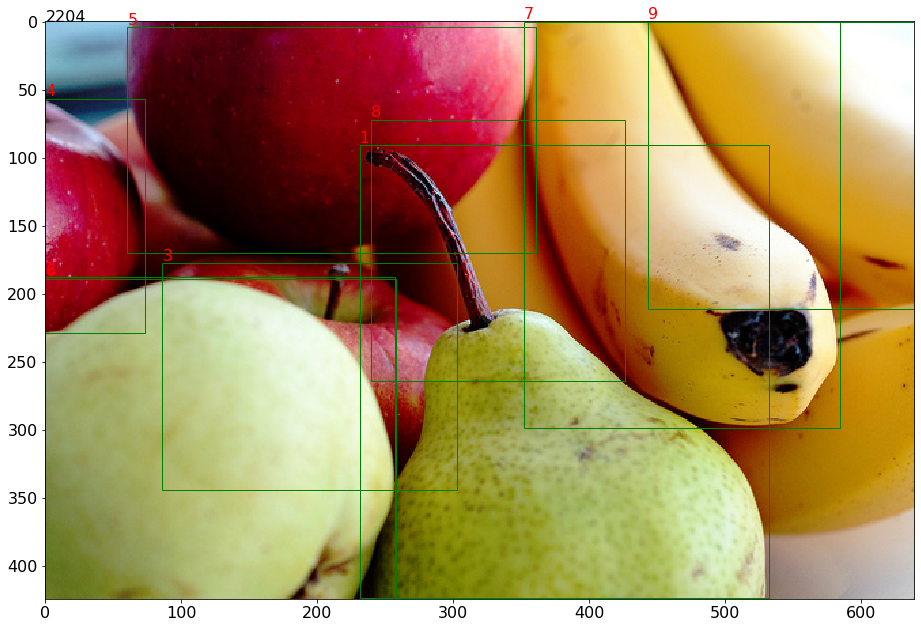

In [166]:
# get an image
category = 'banana'
imgid = np.random.choice(cat_dict[category])
# imgid = 35279
img_idx = data_reader.img_ids.index(imgid)
modal, category, ori_bboxes, _, image_fn = data_reader.get_image_instances(img_idx, with_gt=False)
img_path = os.path.join(img_root, image_fn[13:] if phase == 'val' else image_fn)
img = Image.open(img_path)
image = np.array(img)
height, width = img.height, img.width
plt.figure(figsize=(16, 16./width*height))
plt.imshow(img)
plt.text(0, 0, str(img_idx))
ax = plt.gca()
for i, bbox in enumerate(ori_bboxes):
    rect = patches.Rectangle(bbox[:2], bbox[2], bbox[3], linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    ax.text(bbox[0], bbox[1]-2, str(i+1), color='r')
plt.show()

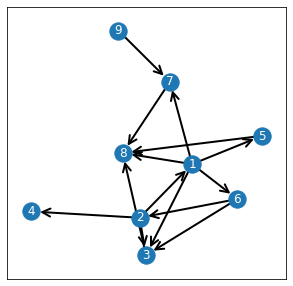

predicted ordering graph, we have no ground truth for LVIS


In [167]:
# infer ordering
bboxes = expand_bbox(ori_bboxes, enlarge_ratio=3., single_ratio=1.1)
order_matrix = infer.infer_order(
    tester.model, image, modal, category, bboxes,
    use_rgb=tester.use_rgb, th=0.1, dilate_kernel=5,
    input_size=256, min_input_size=16, interp='nearest', debug_info=False)
plt.figure(figsize=(5,5))
pos = draw_graph(order_matrix)
plt.show()
print('predicted ordering graph, we have no ground truth for LVIS')

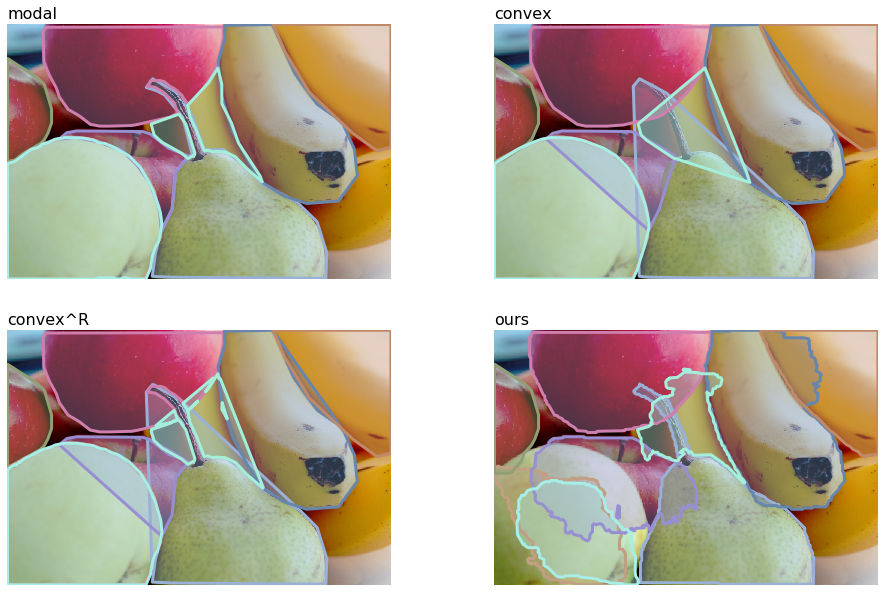

In [168]:
# amodal completion

# convex hull
order_matrix_cvx = infer.infer_order_hull(modal)
amodal_pred_cvx = np.array(infer.infer_amodal_hull(modal, bboxes, None, order_grounded=False))
amodal_pred_cvxr = np.array(infer.infer_amodal_hull(modal, bboxes, order_matrix_cvx, order_grounded=True))

# ours
amodal_patches_pred = infer.infer_amodal(
    tester.model, image, modal, category, bboxes, order_matrix,
    use_rgb=tester.use_rgb, th=0.2, dilate_kernel=3,
    input_size=256, min_input_size=16, interp='linear', debug_info=False)
amodal_pred_ours = infer.patch_to_fullimage(
    amodal_patches_pred, bboxes, image.shape[0], image.shape[1], interp='linear')

# show amodal
exclude = []
rows = 3
cols = 2
bbox_show = [0, 0, 500, height]
bbox_show = None

selidx = np.array([i for i in np.arange(modal.shape[0]) if i not in exclude])
image_show = image[bbox_show[1]:bbox_show[3], bbox_show[0]:bbox_show[2], :] \
    if bbox_show is not None else image.copy()

if bbox_show is not None:
    plt.figure(figsize=(16, 16./(bbox_show[2]-bbox_show[0])*(bbox_show[3]-bbox_show[1]) * 3 / 2))
else:
    plt.figure(figsize=(16, 16./width*height * rows / cols))
    
toshow = [modal, amodal_pred_cvx, amodal_pred_cvxr, amodal_pred_ours]
title = ['modal', 'convex', 'convex^R', 'ours']

# highlight = [np.array([1,1,0.4]), np.array([0.4,1,1]),np.array([0.4,1,0.4])]
colors = [(np.random.random((1, 3)) * 0.6 + 0.4).tolist()[0] for i in range(len(selidx))]
# colors[12] = highlight[0]
# colors[1] = highlight[0]
for i in range(len(toshow)):
    plt.subplot(rows, cols, i + 1)
    ax = plt.gca()
    plt.imshow(image_show)
    plt.axis('off')
    plt.text(0, -10, title[i])
    pface, pedge = polygon_drawing(toshow[i], selidx, colors, bbox_show, thickness=3)
    ax.add_collection(pface)
    ax.add_collection(pedge)
# plt.savefig('outputs/amodal_display/kins_{}.jpg'.format(img_idx), dpi=72)
# cv2.imwrite("outputs/amodal_display/kins_{}_img.jpg".format(img_idx),
#             image_resize(image_sub[:,:,::-1], long_size=480))
plt.show()

In [38]:
modal.shape

(4, 480, 640)

In [158]:
inmodal_show.shape

(148, 148)

In [ ]:
idx=11
idx-=1
otheridx = 3
otheridx-=1
inst = cv2.resize(utils.crop_padding(
    inmodal[idx], bboxes[idx], pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
eraser = cv2.resize(utils.crop_padding(
    inmodal[otheridx], bboxes[otheridx], pad_value=(0,)), (256, 256), interpolation=cv2.INTER_NEAREST)
eraser_setter = EraserSetter(tester.args.data['eraser_setter'])
eraser = eraser_setter(inst, eraser)
cv2.imwrite('/home/xhzhan/Work/tmp/inst.png', inst.astype(np.uint8) * 255)
cv2.imwrite('/home/xhzhan/Work/tmp/eraser_origin.png', eraser.astype(np.uint8) * 255)
cv2.imwrite('/home/xhzhan/Work/tmp/eraser_show.png', eraser.astype(np.uint8) * 128)

show_inst1 = inst.copy().astype(np.float32)
show_inst1[eraser==1] = 0.5

show_inst2 = inst.copy().astype(np.float32)
eraser[inst == 1] = 0
show_inst2[eraser==1] = 0.5

cv2.imwrite('/home/xhzhan/Work/tmp/show_inst1.png', (show_inst1 * 255).astype(np.uint8))
cv2.imwrite('/home/xhzhan/Work/tmp/show_inst2.png', (show_inst2 * 255).astype(np.uint8))

In [ ]:
crop_img = cv2.resize(utils.crop_padding(
    image, bboxes[idx], pad_value=(0,0,0)), (256, 256), interpolation=cv2.INTER_LINEAR)

color=(1,0.6,0)
plt.figure(figsize=(8,8))
# segm = maskUtils.encode(np.asfortranarray(inst))
# poly = coco_segm_to_poly(segm)
poly = mask_to_polygon(inst).reshape((-1, 2))
polygon = patches.Polygon(poly, fill=True, facecolor=color, edgecolor=color, linewidth=3, alpha=0.5)
ax = plt.gca()
plt.imshow(crop_img)
ax.add_patch(polygon)
plt.axis('off')
plt.show()